# Summary:
This notebook will use **Word2Vec** to train an embedding matrix in which each word is represented by a numeric vector with a fixed dimension containing its semantic meaning. The numeric vectors for words in each document are averaged to obtain a vecotr to represent each document. The obtained matrix can be concatenated with the transformed matrix containing information about `Gene` and `Variation`. Machine learning models **LogisticRegression**, **RandomForestClassifier** and **XGBClassifier** will then be applied to the matrix either only containing text information or both text and gene variation data.

# Table of contents
<br >&nbsp;&nbsp;&nbsp;[2.6 Word2Vec](#Part2.6_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.6.1 Train Word2Vec model](#Part2.6.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.6.2 Transform each document into a feature vector](#Part2.6.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.6.3 Train machine learning models using the Word2Vec transformed numeric vectors](#Part2.6.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.6.3.1 LogisticRegression](#Part2.6.3.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.6.3.2 RandomForestClassifier](#Part2.6.3.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.6.3.3 XGBClassifier](#Part2.6.3.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.6.4 Word2Vec + Gene Variation](#Part2.6.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.6.4.1 LogisticRegression](#Part2.6.4.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.6.4.2 RandomForestClassifier](#Part2.6.4.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.6.4.3 XGBClassifier](#Part2.6.4.3_link)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib_venn import venn2
from collections import Counter
from collections import defaultdict
import time

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import gensim
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
from matplotlib_venn import venn2
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from ast import literal_eval

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import itertools
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
base_dir='/Volumes/Yuchen_Drive/Personalized_Medicine'

Load preprocessed training files from the previous notebook.

In [6]:
train_df=pd.read_csv(os.path.join(base_dir,'pre/train_df_1.csv'))
test_df=pd.read_csv(os.path.join(base_dir,'pre/test_df_1.csv'))
train_df.head()

,ID,Text,Gene,Variation,Class,sent_length,word_length
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1,326,7313
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2,248,6784
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2,248,6784
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3,185,6396
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4,262,7248


In [7]:
def preprocess(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

In [8]:
train_df['text_clean'] = preprocess(train_df.Text)
test_df['text_clean'] = preprocess(test_df.Text)

In [9]:
custom_words = ["fig", "figure", "et", "al", "al.", "also",
                "data", "analyze", "study", "table", "using",
                "method", "result", "conclusion", "author", 
                "find", "found", "show", '"', "’", "“", "”",
                "assayed", "assay", "assays","figures", "figure","data", "sample","samples","table","tables",
                'proteins','protein','cells','cell','genes','gene',
                'mutated','mutation','mutational','mutations','mutate','mutant','mutants',
                'cancer','cancers','tumor','tumors','variant','variants']
stop_word1 = gensim.parsing.preprocessing.STOPWORDS   ## 337
stop_word2 = nltk.corpus.stopwords.words('english')   ## 179
stop_words = set(list(stop_word1)+stop_word2+custom_words)   ## 433

In [10]:
bow=list(train_df.Text)+list(test_df.Text)

In [11]:
bow_clean=list(train_df.text_clean)+list(test_df.text_clean)

<a id='Part2.6_link'></a>
## 2.6 Word2Vec

Instead of using CountVectorizer and TfidfVectorizer to convert words, we can use **Word2Vec** to train an embedding matrix. **Word2Vec** model is used for learning vector representations of words called “word embeddings” in which each word is represented by a numeric vector. The vector representations of words contain semantic meaning for each word as well as the word context. Words similar in meaning or in the same context will be represented by vectors closer to each other in the vector space. Relationships between words can be represented by distance in vector space. 

One of the advantages of Word2Vec is that it uses the embedding matrix to represent each word with a dense vector of a specified dimension, which is much smaller compared to the sparse matrix used in CountVectorizer and TfidfVectorizer methods. Although the Latent Semantic Analysis (LSA) can also reduce vector dimension, this count-based method only computes how often some word co-occurs with its neighbor words in a large text corpus. **Word2Vec** directly predicts a word from its neighbors by training weights in the hidden layer of the neural network. The number of hidden units in the hidden layer equals the dimensions of the embedding matrix as well as the vector representations.

There are two architectures for implementing Word2Vec:
1. **Continuous Bag-of-Words model (CBOW) model**: predict target words from source context words
2. **Skip-Gram model**: predict source context-words from the target words

Here I use `gensim.models.Word2Vec` to train a **Word2Vec** model.

<a id='Part2.6.1_link'></a>
### 2.6.1 Train Word2Vec model

In [189]:
## Method 1
class MySentences(object):
    """ Credits go to https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm
        MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    # print(sent)
                    yield nltk.word_tokenize(sent)

In [10]:
## Method 1
text_array = np.append(train_df.Text.values, test_df.Text.values)
print('length of text_array: {}'.format(len(text_array)))

length of text_array: 8983


In [11]:
## Method 1
text_corpus=MySentences(text_array)
print(next(iter(text_corpus)))

['Cyclin-dependent', 'kinases', '(', 'CDKs', ')', 'regulate', 'a', 'variety', 'of', 'fundamental', 'cellular', 'processes', '.']


Here I choose to use embedding size as 100. After conversion, each word will be represented by a numeric vector with dimension as 100.

In [14]:
## Method 1
# word2vec=gensim.models.Word2Vec(text_corpus,size=100, window=5, min_count=5, workers=4)
location = os.path.join(base_dir, 'preprocessing/personalized_medicine_w2vmodel_dim100.w2v')
# word2vec.save(location)
print('Model done training. Saving to {}'.format(location))
word2vec = gensim.models.Word2Vec.load(location)

Model done training. Saving to /Volumes/Yuchen_Drive/Personalized_Medicine/preprocessing/personalized_medicine_w2vmodel_dim100.w2v


In [187]:
## Method 1
text_array = np.append(train_df.Text.values, test_df.Text.values)
print('length of text_array: {}'.format(len(text_array)))

length of text_array: 8983


In [190]:
## Method 1
text_corpus=MySentences(text_array)
print(next(iter(text_corpus)))

['Cyclin-dependent', 'kinases', '(', 'CDKs', ')', 'regulate', 'a', 'variety', 'of', 'fundamental', 'cellular', 'processes', '.']


In [191]:
## Method 1
word2vec=gensim.models.Word2Vec(text_corpus,size=300, window=5, min_count=1, workers=4)
location = os.path.join(base_dir, 'preprocessing/personalized_medicine_w2vmodel_RNN_dim300.w2v')
word2vec.save(location)
print('Model done training. Saving to {}'.format(location))
#word2vec = gensim.models.Word2Vec.load(location)

Model done training. Saving to /Volumes/Yuchen_Drive/Personalized_Medicine/preprocessing/personalized_medicine_w2vmodel_RNN_dim300.w2v


Before moving forward to converting texts to vector representations, we can first look at the important attributes of the trained word2vec model.

In [15]:
## get embedding dimension of word2vec (dimensionality of the word vectors)
dim=len(word2vec.wv.syn0[0])
print('The dimension of the embedding matrix for word2vec is {}'.format(dim))

The dimension of the embedding matrix for word2vec is 100


In [16]:
## get size of the vocabulary
print('Vocabulary size: {}'.format(len(word2vec.wv.index2word)))
print('Sample words in the vocabulary: {}'.format(word2vec.wv.index2word[:10]))
print('embedding matrix shape: {}'.format(word2vec.wv.vectors.shape))

Vocabulary size: 249524
Sample words in the vocabulary: [',', '.', 'the', 'of', 'and', '(', ')', 'in', 'to', 'with']
embedding matrix shape: (249524, 100)


In [17]:
## get vector representation for word 'cyclin'
print(len(word2vec.wv['cyclin']))
print("Vector representation for 'cyclin': {}".format(word2vec.wv['cyclin']))

100
Vector representation for 'cyclin': [-2.06155386e-02  3.06514263e+00  1.65056205e+00  2.10751557e+00
 -2.58445907e+00  3.52593517e+00  2.40017915e+00 -3.23320580e+00
  7.44677544e-01  9.41748142e-01  1.86502349e+00 -1.10979426e+00
  2.51290774e+00 -3.43338132e+00 -1.65640342e+00 -1.35059524e+00
 -4.44462359e-01 -1.04855561e+00  4.26486164e-01  2.26491356e+00
  6.12560689e-01 -1.79326093e+00  1.09174418e+00 -2.07446241e+00
 -3.04178071e+00  6.51311362e-03 -3.34650636e+00 -4.69646990e-01
 -7.25147438e+00  6.05820775e-01 -2.71873564e-01 -1.65633941e+00
 -4.15732193e+00  5.06637096e+00 -4.80983829e+00  2.51799822e+00
  2.43308020e+00 -1.34390628e+00  2.33013606e+00  2.33880520e+00
  7.08007514e-01 -2.52078176e+00  2.61000586e+00  1.02142835e+00
  7.10690856e-01 -1.52708948e+00  1.76703882e+00  3.77391005e+00
  3.20123887e+00 -2.53282022e+00  4.98091459e+00 -1.70393670e+00
 -1.17877626e+00  5.99166441e+00 -1.19282091e+00 -1.40156075e-01
 -3.32299399e+00  4.15526962e+00 -2.47388458e+00  

In [18]:
## get 'most_similar' words
result,scores = zip(*word2vec.most_similar(positive=['benign','passenger'], negative=['malignant','aggressive'],topn=20))
print(result)

('non-pathogenic', 'conservatively', 'nonpathogenic', 'dbSNP', 'o60', 'silent', 'synonymous', 'controls', 'noncoding', 'NS/SS/I', 'neutral', 'harmless', 'splice-site', 'zero', 'protein-truncating', 'pathogenic', 'bars/black', 'single-nucleotide', 'DME1+', 'non-hotspot')


Here I try to get words with semantic meaning similar to `benign` and `passenger`, opposite to `malignant` and `aggressive`. The output words include `non-pathogenic`, `nonpathogenic`, `neutral`, `harmless`, which have the same meaning as `benign` in description of cancer. Words like `silent`, `controls`, `zero` also hold similar semantic meanings.

In [19]:
## get 'most_similar' words
result,scores = zip(*word2vec.most_similar(positive=['malignant','aggressive'], negative=['benign','passenger'],topn=20))
print(result)

('epithelial-like', 'stress-resistant', 'Satoh', 'advanced', 'indolent', 'macrophage-like', 'FIG–ROS-driven', 'B2-type', 'Chronic', 'B-lymphoid', 'MLL-AF9–driven', 'RMS', 'Systemic', 'impressive', 'adipocyte', 'monoblastic', 'Aggressive', 'x-ray-irradiated', 'myelofibrosis-like', 'aggres')


Conversely, words like `advanced` and `aggres` have similar semantic meanings to `malignant`, but opposite to `benign`.

**t-SNE** (t-distributed Stochastic Neighbor Embedding) is a non-linear dimensionality reduction approach for visualization of high-dimensional data in a two- or three-dimensional space. We can visualize the spatial distribution of numeric representations of the words with semantic meanings similar to `benign` and `malignant` in t-SNE plot.

In [111]:
index_list=[]
result1,scores = zip(*word2vec.most_similar(positive=['benign','passenger'], negative=['malignant','aggressive'],topn=50))
result2,scores = zip(*word2vec.most_similar(positive=['malignant','aggressive'], negative=['benign','passenger'],topn=50))
word_list=list(result1)+list(result2)
for word in word_list:
    index_list.append(word2vec.wv.index2word.index(word))
tsne = TSNE()
embed_tsne = tsne.fit_transform(word2vec.wv.vectors[index_list, :])
embed_df=pd.DataFrame({'word':np.array(word_list),'tsne1':embed_tsne[:,0],'tsne2':embed_tsne[:,1],'color':np.append(np.repeat('benign',len(embed_tsne)//2),np.repeat('malignant',len(embed_tsne)//2))})

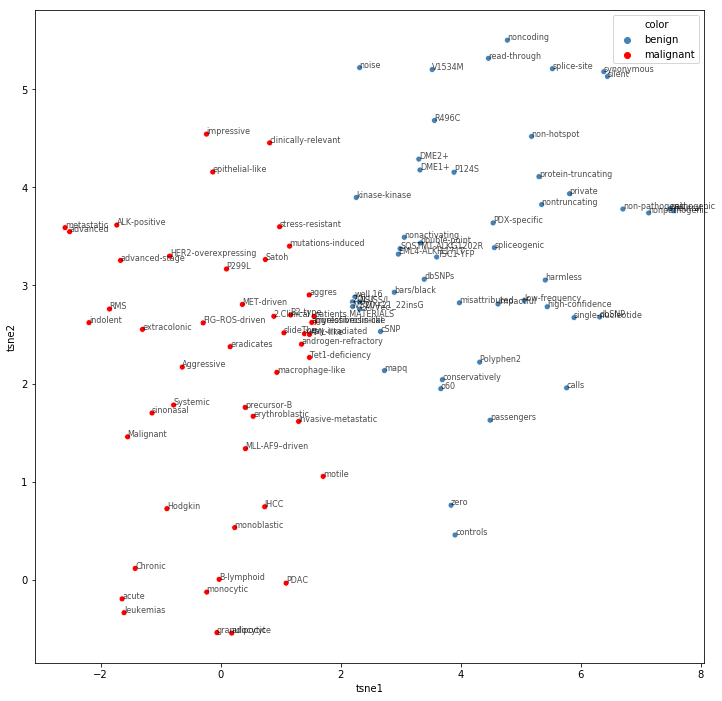

In [112]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',y='tsne2',data=embed_df,hue='color',palette=['steelblue','red'],ax=ax)
for idx in range(len(index_list)):
    ax.annotate(word_list[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7,size=8)

Based on the t-SNE plot plot, there is a clear separation between words similar to `benign` and words similar to `malignant`. Tumor metastasis is closely associated with advanced tumor stage and cancer-related deaths. Word `metastatic` is very close to `advanced` in t-SNE plot based on numeric vector representations obtained from trained Word2Vec model. `PDAC` (pancreatic ductal adenocarcinoma) is the most common type of pancreatic cancer with very poor prognosis. It is also very `malignant` based on the Word2Vec vector representation. 

<a id='Part2.6.2_link'></a>
### 2.6.2 Transform each document into a feature vector

Each word can be represented by a vector of 100 dimensions using the trained **Word2Vec** model. For each document, the numerical vectors of all the words are averaged to obtain a feature vector for the document.

In [113]:
## Method 1
class MyTokenizer:
    """
    Credits go to https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [114]:
## Method 1
class MeanEmbeddingVectorizer(object):
    """
    Credits go to https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm
    """
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [ ]:
## Method 1
mean_embedding_vectorizer = MeanEmbeddingVectorizer(word2vec)
mean_embedded = mean_embedding_vectorizer.fit_transform(train_df.Text.values)
pd.DataFrame(mean_embedded).to_csv(os.path.join(base_dir, 'preprocessing/personalized_medicine_w2vmodel_dim100_mean_embedded.csv'),index=False)

In [115]:
## Method 1
mean_embedded=pd.read_csv(os.path.join(base_dir, 'preprocessing/personalized_medicine_w2vmodel_dim100_mean_embedded.csv'))
mean_embeded=np.array(mean_embedded)
print(mean_embedded.shape)

(3316, 100)


In [184]:
tsne = TSNE()
embed_tsne = tsne.fit_transform(mean_embedded)
embed_df=pd.DataFrame({'tsne1':embed_tsne[:,0],'tsne2':embed_tsne[:,1],'class':train_df.Class.values})

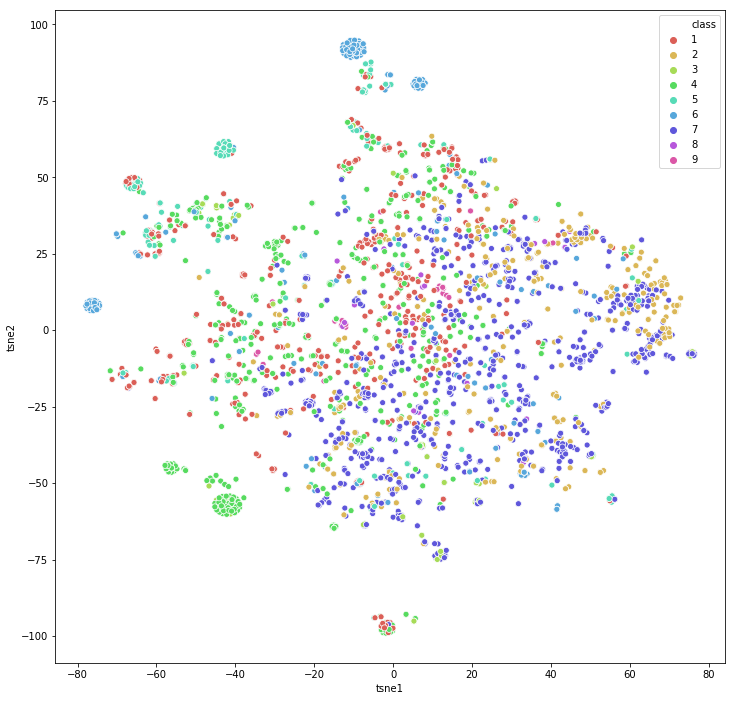

In [186]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',y='tsne2',data=embed_df,hue='class',hue_order=list(np.arange(1,10)),palette=sns.color_palette('hls',9),ax=ax)

We cannot observe distinct clusters using t-SNE plot, which suggests that machine learning models are needed to further classify each document.

<a id='Part2.6.3_link'></a>
### 2.6.3 Train machine learning models using the Word2Vec transformed numeric vectors

Here are some functions used in model evaluation.

In [117]:
def plot_val_curve(train_scores,test_scores,param_name, param_vals,title,logx=True):
    train_mean = train_scores.mean(axis=1)
    print('{}: {}'.format(param_name, param_vals))
    print('train_mean: {}'.format(train_mean))
    train_std = train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    print('test_mean: {}'.format(test_mean))
    print('-'*80)
    print('{}: {} achieves highest test score: {}'.format(param_name,param_vals[np.argmax(test_mean)], test_mean.max()))
    print('-'*80)
    test_std = test_scores.std(axis=1)
    fig,ax=plt.subplots(1,1,figsize = (12,5))
    plt.title(title,fontsize=18)
    if logx:
        plt.semilogx(param_vals, train_mean, 'o-', color = 'r', label = 'Training Score')
        plt.semilogx(param_vals, test_mean, 'o-', color = 'b', label = 'Validation Score')
    else:
        plt.plot(param_vals, train_mean, 'o-', color = 'r', label = 'Training Score')
        plt.plot(param_vals, test_mean, 'o-', color = 'b', label = 'Validation Score')
    plt.fill_between(param_vals, train_mean-train_std, train_mean+train_std, alpha = 0.15, color = 'r')
    plt.fill_between(param_vals, test_mean-train_std, test_mean+test_std, alpha = 0.15, color = 'b')
    plt.legend(loc = 'lower right')
    plt.xlabel('{}'.format(param_name),fontsize=12)
    plt.ylabel('Score',fontsize=12)
    plt.ylim([-0.05,1.05])
    ax.vlines(param_vals[np.argmax(test_mean)], -0.05, 1.05, linestyles='-.', color = sns.xkcd_rgb["pale red"])
    plt.show()

In [122]:
def model_eval(clf, X, y):
    cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
    probas = cross_val_predict(clf, X, y, cv=cv, n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    preds=np.unique(y)[pred_indices]
    accuracy = accuracy_score(y, preds)
    logloss = log_loss(y, probas)
    print('accuracy score: {}'.format(accuracy))
    print('log_loss: {}'.format(logloss))
    output = pd.DataFrame(probas,columns=['Class{}'.format(i) for i in range(1,10)])
    output['pred']=preds
    return output

In [124]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar(shrink=0.8)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(tick_marks, classes, fontsize=12, fontweight='bold')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:d} \n({:.2f}%)'.format(cm[i, j], cm[i,j]/cm.sum()*100), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.tight_layout()

In [132]:
def plot_acc_bar(cm,total_acc):
    acc=[cm[i][i] for i in range(len(classes))]
    acc_freq=acc/cm.sum(axis=1)
    fig = plt.figure(figsize = (20,8))
    ax = fig.add_subplot(1,1,1)
    width = 0.75 # the width of the bars 
    ind = np.arange(len(classes))  # the x locations for the groups
    ax.bar(ind, np.round(acc_freq*100,2), width, edgecolor='black', color = sns.color_palette('hls', len(classes)))
    plt.xticks(ind, labels = classes, fontsize=18, fontweight='bold', rotation=45)
    plt.yticks(fontsize=16)
    plt.xlabel('Category', fontsize=18)
    plt.ylabel('Accuracy%', fontsize=18)
    for i, v in enumerate(np.round(acc_freq*100,2)):
        ax.text(i-0.25, v + 1, str(np.round(v,2))+'%', fontweight='bold', fontsize=18)
        ax.plot([-0.5, 8.5], [total_acc, total_acc], "k--", linewidth=2)
    ax.text(8.5, total_acc, 'Avg:\n'+str(total_acc)+'%', fontweight='bold', fontsize=18)

In [136]:
def plot_ROC_curve(acc_df):
    probas=np.array(output.drop(['pred'],axis=1))

    fpr = dict()
    tpr = dict()
    auc_list = []
    label_to_class_dict = {i:l for i,l in enumerate(classes)}
    for i in np.arange(len(classes)):
        true_label_array = (y == i+1).astype(np.uint8)
        probs = probas[:,i]
        fpr[i], tpr[i], _ = roc_curve(true_label_array, probs)
        auc_value = auc(fpr[i], tpr[i])
        auc_list.append(auc_value)

    palette=sns.color_palette('hls',len(classes))
    for i in np.arange(len(classes)):
        plt.plot(fpr[i], tpr[i], color = palette[i], label='{} (area = {:.2f})'.format(classes[i], auc_list[i]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

<a id='Part2.6.3.1_link'></a>
### 2.6.3.1 LogisticRegression

* Model: StandardScaler + LogisticRegression

C: [1.00000000e-05 2.84803587e-05 8.11130831e-05 2.31012970e-04
 6.57933225e-04 1.87381742e-03 5.33669923e-03 1.51991108e-02
 4.32876128e-02 1.23284674e-01 3.51119173e-01 1.00000000e+00]
train_mean: [0.28709311 0.30405822 0.40229112 0.46857643 0.51485884 0.55692631
 0.57704853 0.59476671 0.6136909  0.6231888  0.63736615 0.64709044]
test_mean: [0.28709658 0.29921284 0.38851587 0.43075701 0.45968384 0.46206991
 0.46564547 0.46777745 0.45933315 0.44395861 0.43612035 0.43192248]
--------------------------------------------------------------------------------
C: 0.01519911082952933 achieves highest test score: 0.467777450458892
--------------------------------------------------------------------------------


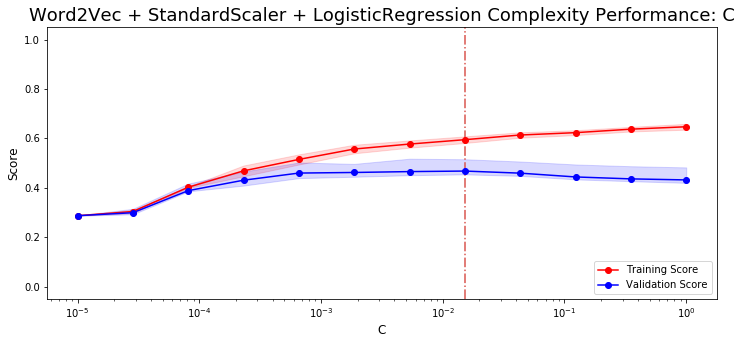

In [118]:
ss = StandardScaler(with_mean=False)
X=ss.fit_transform(mean_embedded)
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
c_vals=np.logspace(-5,0,12)
train_scores, test_scores = validation_curve(LogisticRegression(n_jobs=-1,random_state=8), X, y, param_name = 'C', param_range = c_vals, cv = cv, scoring = 'accuracy')
title='Word2Vec + StandardScaler + LogisticRegression Complexity Performance: C'
plot_val_curve(train_scores,test_scores,'C', c_vals,title,logx=True)

In [160]:
ss=StandardScaler(with_mean=False)
X=ss.fit_transform(mean_embedded)
y=train_df.Class.values
lr=LogisticRegression(n_jobs=-1,random_state=8)
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
params={"C":[0.01,0.015,0.05,0.1,0.2]}
clf=GridSearchCV(lr, param_grid=params, cv=cv, scoring = 'accuracy',return_train_score=True)
clf.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8, shuffle=False),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=-1, penalty='l2',
                                          random_state=8, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.01, 0.015, 0.05, 0.1, 0.2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [161]:
print("C: {}".format(clf.best_estimator_.get_params()['C']))
# pd.DataFrame.from_dict(clf.cv_results_)

C: 0.01


In [162]:
ss=StandardScaler(with_mean=False)
X=ss.fit_transform(mean_embedded)
y=train_df.Class.values
lr=LogisticRegression(n_jobs=-1,random_state=8)
output = model_eval(clf, X,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   20.4s remaining:   30.6s


accuracy score: 0.46712907117008445
log_loss: 1.4412885778333229


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.9s finished


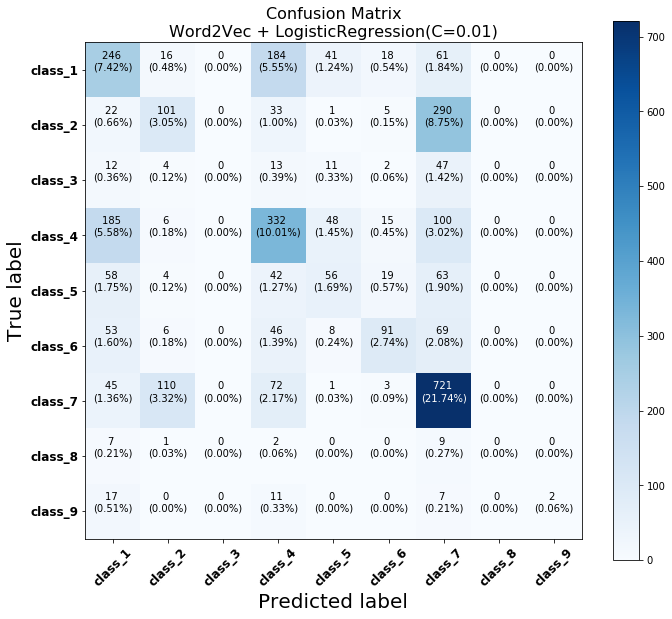

In [163]:
cm = confusion_matrix(train_df.Class.values, output.pred)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nWord2Vec + LogisticRegression(C=0.01)', cmap=plt.cm.Blues)

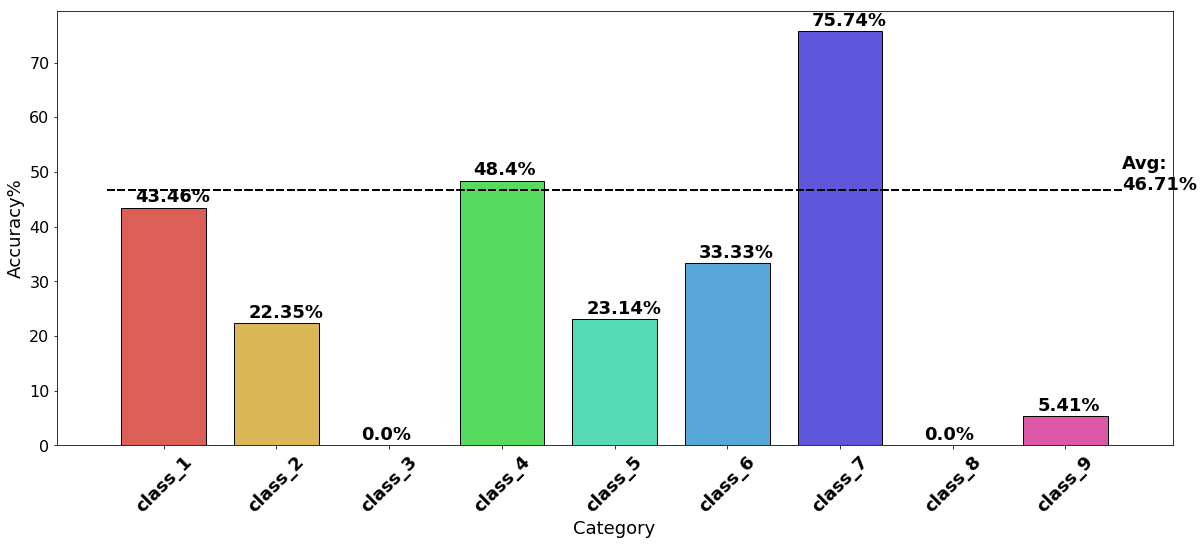

In [164]:
plot_acc_bar(cm,46.71)

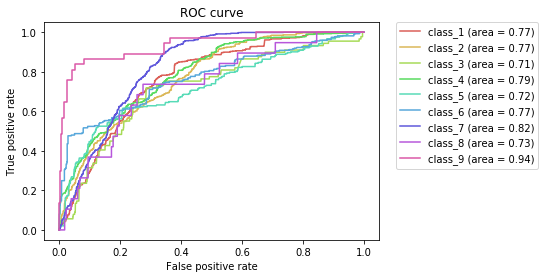

In [165]:
plot_ROC_curve(output)

This model is highly biased. The majority of documents in `Class2` are classified as `Class7` and a large percentage of documents in `Class1` are classified as `Class4` and `Class7`.

<a id='Part2.6.3.2_link'></a>
### 2.6.3.2 RandomForestClassifier

* Model: RandomForestClassifier

max_depth: [   1    3    5   10   20   50  100 1000]
train_mean: [0.39225775 0.50128146 0.60954295 0.83089368 0.89452821 0.89701591
 0.89701591 0.89701591]
test_mean: [0.37785349 0.44090183 0.45461044 0.44644053 0.43192461 0.42620235
 0.42620235 0.42620235]
--------------------------------------------------------------------------------
max_depth: 5 achieves highest test score: 0.4546104375227825
--------------------------------------------------------------------------------


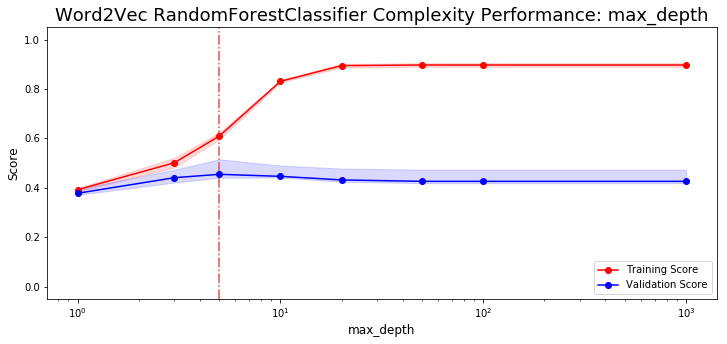

In [139]:
X=mean_embedded
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
max_depth=np.array([1,3,5,10,20,50,100,None])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'max_depth', param_range = max_depth, cv = cv, scoring = 'accuracy')
max_depth=np.array([1,3,5,10,20,50,100,1000])
title='Word2Vec RandomForestClassifier Complexity Performance: max_depth'
plot_val_curve(train_scores,test_scores,'max_depth', max_depth,title,logx=True)

min_samples_leaf: [  1   5  15 100 300 500]
train_mean: [0.89701591 0.81921343 0.70657041 0.52586701 0.43969838 0.40153649]
test_mean: [0.42620235 0.47172955 0.45575388 0.44728783 0.3995965  0.38927482]
--------------------------------------------------------------------------------
min_samples_leaf: 5 achieves highest test score: 0.4717295515674496
--------------------------------------------------------------------------------


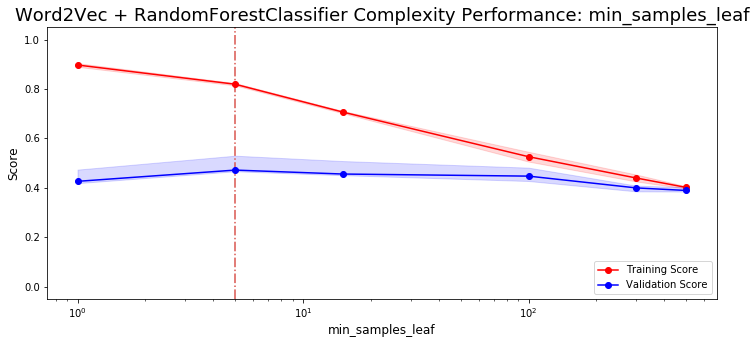

In [148]:
X=mean_embedded
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
min_samples_leaf=np.array([1,5,15,100,300,500])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'min_samples_leaf', param_range = min_samples_leaf, cv = cv, scoring = 'accuracy')
title='Word2Vec + RandomForestClassifier Complexity Performance: min_samples_leaf'
plot_val_curve(train_scores,test_scores,'min_samples_leaf', min_samples_leaf,title,logx=True)

In [141]:
X=mean_embedded
y=train_df.Class.values
clf = RandomForestClassifier(max_depth=None,min_samples_leaf=5,n_jobs=-1,random_state=8)
output = model_eval(clf, X,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


accuracy score: 0.47165259348612787
log_loss: 2.8611842302800428


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [142]:
X=mean_embedded
y=train_df.Class.values
clf = RandomForestClassifier(max_depth=5,min_samples_leaf=5,n_jobs=-1,random_state=8)
output = model_eval(clf, X,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.8s


accuracy score: 0.4502412545235223
log_loss: 1.518309659605151


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


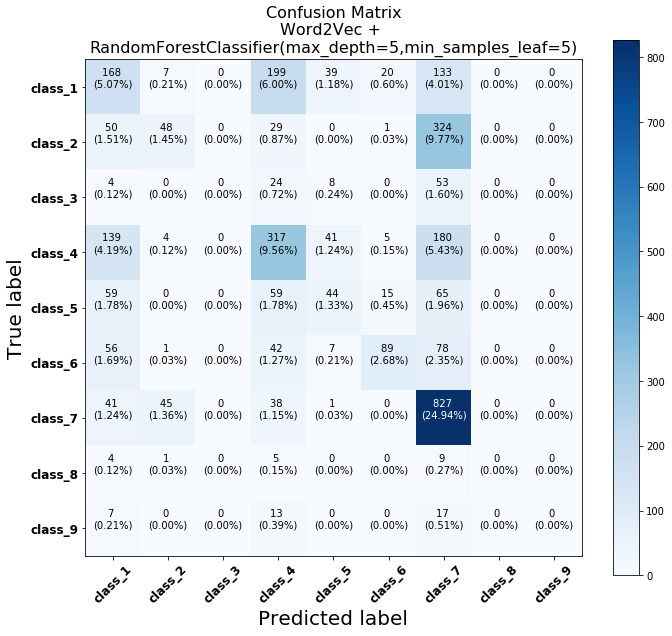

In [145]:
cm = confusion_matrix(train_df.Class.values, output.pred)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nWord2Vec + \nRandomForestClassifier(max_depth=5,min_samples_leaf=5)', cmap=plt.cm.Blues)

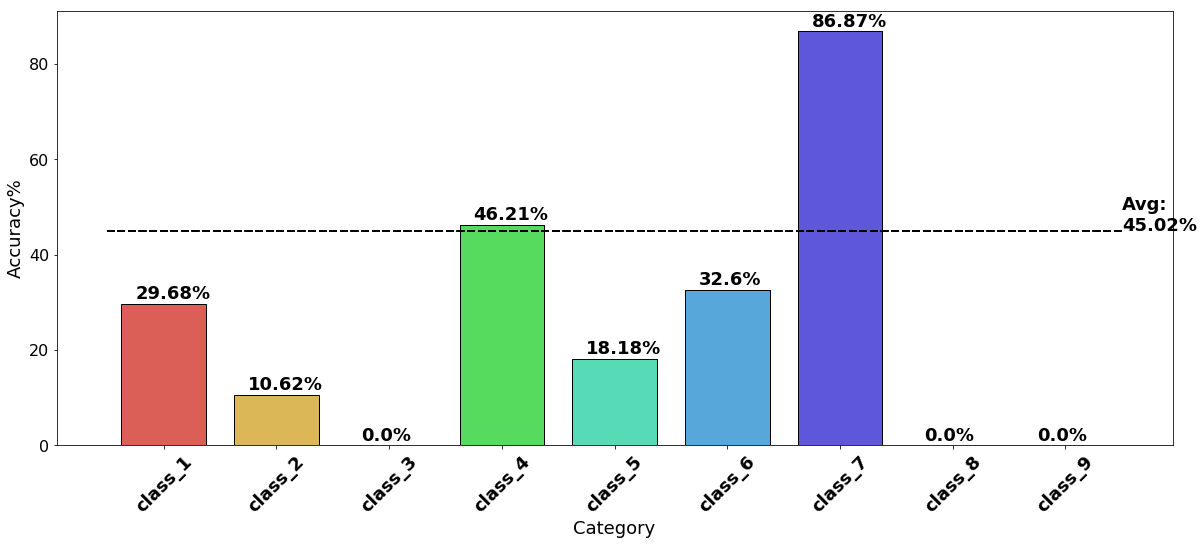

In [146]:
plot_acc_bar(cm,45.02)

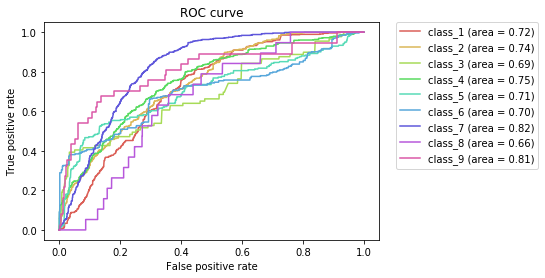

In [147]:
plot_ROC_curve(output)

<a id='Part2.6.3.3_link'></a>
### 2.6.3.3 XGBClassifier

* Model: XGBClassifier

colsample_bytree: [0.2 0.4 0.6 0.8 1. ]
train_mean: [0.80813046 0.81167135 0.81114344 0.81513961 0.816798  ]
test_mean: [0.47624512 0.47113401 0.47229933 0.47323127 0.47744858]
--------------------------------------------------------------------------------
colsample_bytree: 1.0 achieves highest test score: 0.47744857754671655
--------------------------------------------------------------------------------


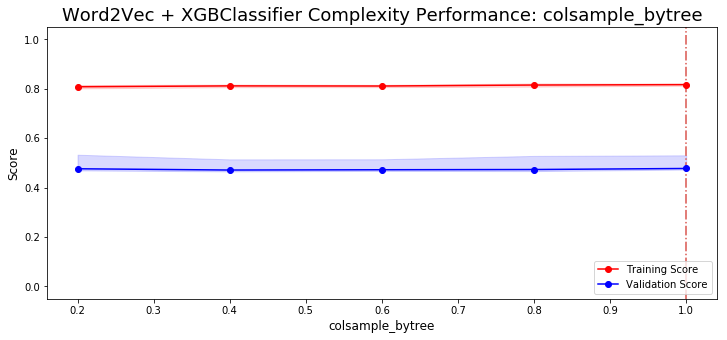

In [149]:
X=mean_embedded
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
colsample_bytree=np.array([0.2, 0.4, 0.6, 0.8, 1.0])
train_scores, test_scores = validation_curve(XGBClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'colsample_bytree', param_range = colsample_bytree, cv = cv, scoring = 'accuracy')
title='Word2Vec + XGBClassifier Complexity Performance: colsample_bytree'
plot_val_curve(train_scores,test_scores,'colsample_bytree', colsample_bytree,title,logx=False)

min_child_weight: [ 1  3  5  8 10 20]
train_mean: [0.816798   0.81265106 0.80722227 0.80300093 0.7981766  0.77653679]
test_mean: [0.47744858 0.47802878 0.48229256 0.47019491 0.47745264 0.47562082]
--------------------------------------------------------------------------------
min_child_weight: 5 achieves highest test score: 0.48229256493707695
--------------------------------------------------------------------------------


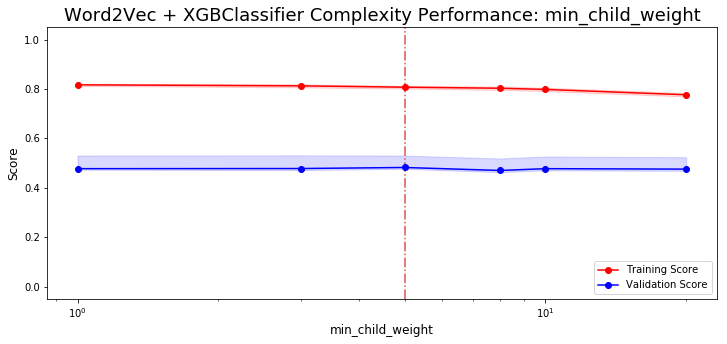

In [150]:
X=mean_embedded
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
min_child_weight=np.array([1, 3, 5, 8, 10, 20])
train_scores, test_scores = validation_curve(XGBClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'min_child_weight', param_range = min_child_weight, cv = cv, scoring = 'accuracy')
title='Word2Vec + XGBClassifier Complexity Performance: min_child_weight'
plot_val_curve(train_scores,test_scores,'min_child_weight', min_child_weight,title,logx=True)

In [151]:
X=mean_embedded
y=train_df.Class.values
clf = XGBClassifier(min_child_weight=5)
output = model_eval(clf, X,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.6s remaining:   35.4s


accuracy score: 0.4822074788902292
log_loss: 1.4920899699362324


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.0s finished


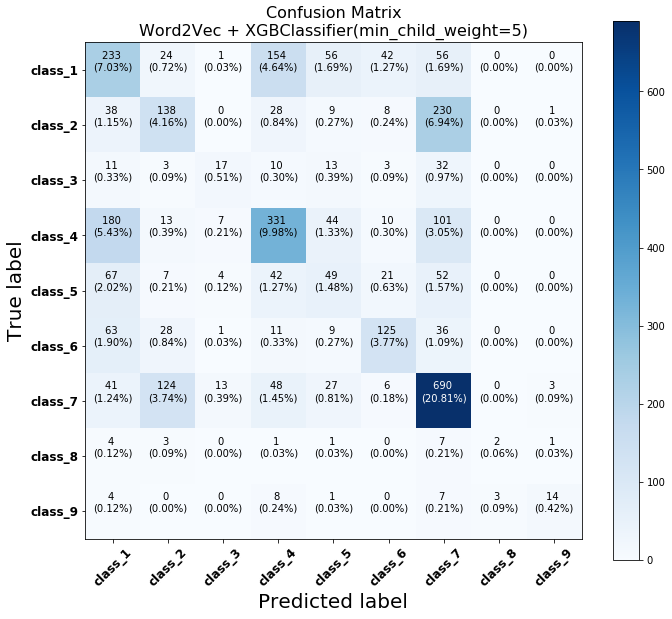

In [152]:
cm = confusion_matrix(train_df.Class.values, output.pred)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nWord2Vec + XGBClassifier(min_child_weight=5)', cmap=plt.cm.Blues)

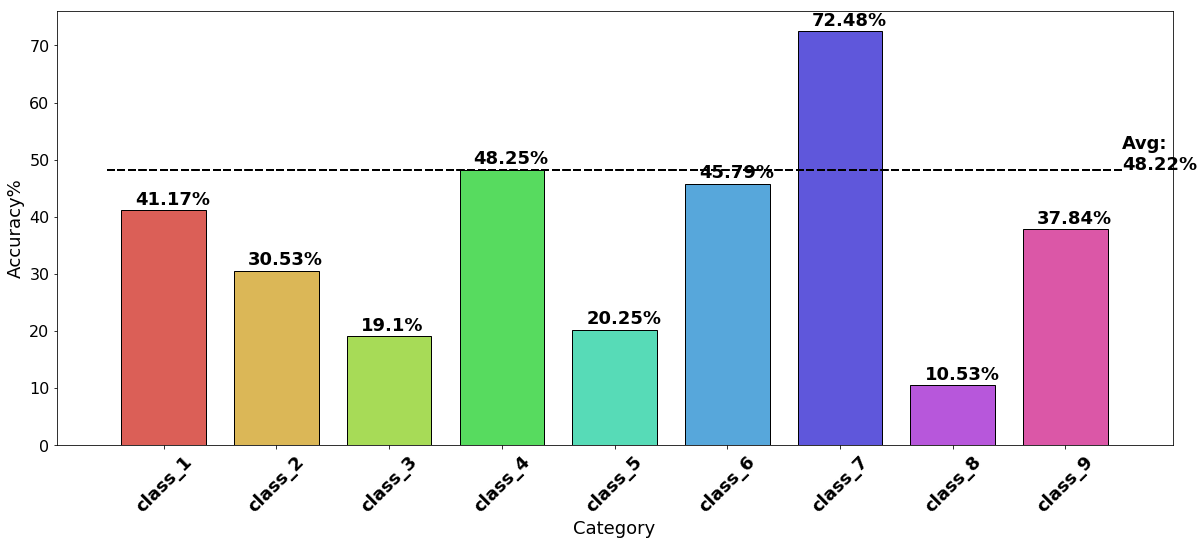

In [153]:
plot_acc_bar(cm,48.22)

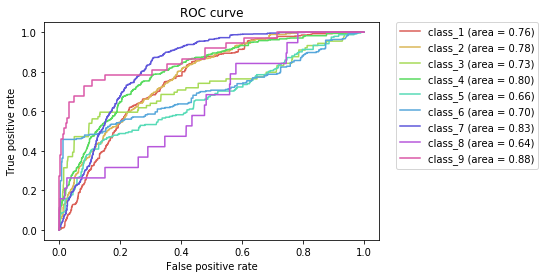

In [154]:
plot_ROC_curve(output)

<a id='Part2.6.4_link'></a>
### 2.6.4 Word2Vec + Gene Variation

Similar to `LSA`, `Gene` and `Variation` can be represented by numeric vectors with one-hot-encoding and TruncatedSVD. The obtained output is concatenated with the output of Word2Vec. Machine learning models can then be applied to the combined vectors containing information about both text and gene variation. 

#### Convert Gene and Variation

In [185]:
data_df=train_df.append(test_df, ignore_index=True, sort=False)
one_hot_gene=pd.get_dummies(data_df.Gene)
one_hot_variation=pd.get_dummies(data_df.Variation)
svd=TruncatedSVD(n_components=25, n_iter=25, random_state=8)
one_hot_gene_truncated=svd.fit_transform(one_hot_gene.values)
svd=TruncatedSVD(n_components=25, n_iter=25, random_state=8)
one_hot_variation_truncated=svd.fit_transform(one_hot_variation.values)
train_set=np.concatenate((one_hot_gene_truncated[:len(train_df)],one_hot_variation_truncated[:len(train_df)],mean_embedded), axis=1)
print('train_set.shape: {}'.format(train_set.shape))

train_set.shape: (3316, 150)


<a id='Part2.6.4.1_link'></a>
### 2.6.4.1 LogisticRegression

* Model: StandardScaler + LogisticRegression

C: [1.00000000e-05 2.84803587e-05 8.11130831e-05 2.31012970e-04
 6.57933225e-04 1.87381742e-03 5.33669923e-03 1.51991108e-02
 4.32876128e-02 1.23284674e-01 3.51119173e-01 1.00000000e+00]
train_mean: [0.28709311 0.33105459 0.42303769 0.51742562 0.56513477 0.60320892
 0.62138516 0.65319543 0.66963025 0.6838833  0.69496812 0.70725387]
test_mean: [0.28709658 0.30224774 0.39153569 0.46430967 0.50218128 0.50548486
 0.47381928 0.44665459 0.42401357 0.42252214 0.41257643 0.41320458]
--------------------------------------------------------------------------------
C: 0.001873817422860383 achieves highest test score: 0.5054848584803736
--------------------------------------------------------------------------------


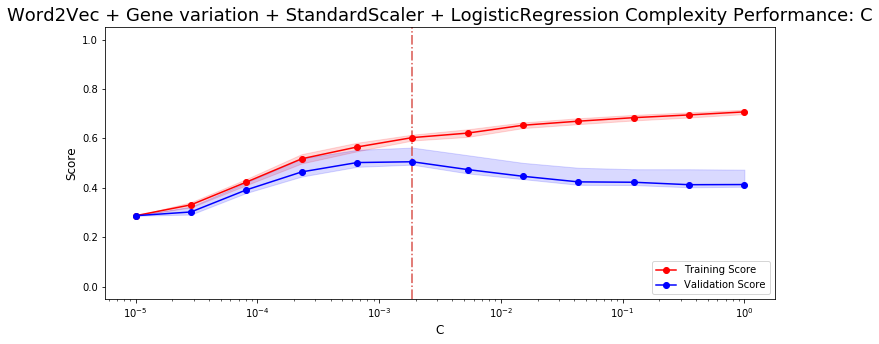

In [156]:
ss = StandardScaler(with_mean=False)
X=ss.fit_transform(train_set)
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
c_vals=np.logspace(-5,0,12)
train_scores, test_scores = validation_curve(LogisticRegression(n_jobs=-1,random_state=8), X, y, param_name = 'C', param_range = c_vals, cv = cv, scoring = 'accuracy')
title='Word2Vec + Gene variation + StandardScaler + LogisticRegression Complexity Performance: C'
plot_val_curve(train_scores,test_scores,'C', c_vals,title,logx=True)

In [166]:
ss=StandardScaler(with_mean=False)
X=ss.fit_transform(train_set)
y=train_df.Class.values
lr=LogisticRegression(n_jobs=-1,random_state=8)
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
params={"C":[0.001,0.002,0.005,0.01]}
clf=GridSearchCV(lr, param_grid=params, cv=cv, scoring = 'accuracy',return_train_score=True)
clf.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8, shuffle=False),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=-1, penalty='l2',
                                          random_state=8, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.002, 0.005, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [167]:
print("C: {}".format(clf.best_estimator_.get_params()['C']))
# pd.DataFrame.from_dict(clf.cv_results_)

C: 0.001


In [168]:
ss=StandardScaler(with_mean=False)
X=ss.fit_transform(train_set)
y=train_df.Class.values
lr=LogisticRegression(n_jobs=-1,random_state=8)
output = model_eval(clf, X,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


accuracy score: 0.5135705669481303
log_loss: 1.463174311860312


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.1s remaining:   18.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.2s finished


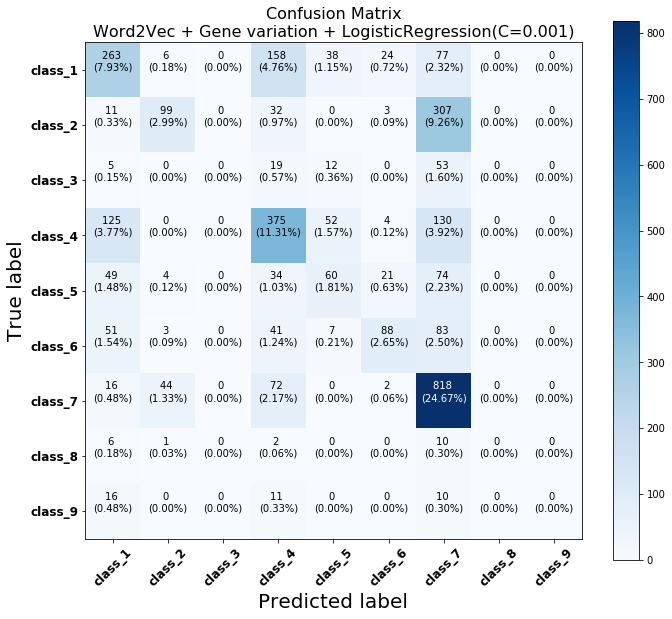

In [169]:
cm = confusion_matrix(train_df.Class.values, output.pred)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nWord2Vec + Gene variation + LogisticRegression(C=0.001)', cmap=plt.cm.Blues)

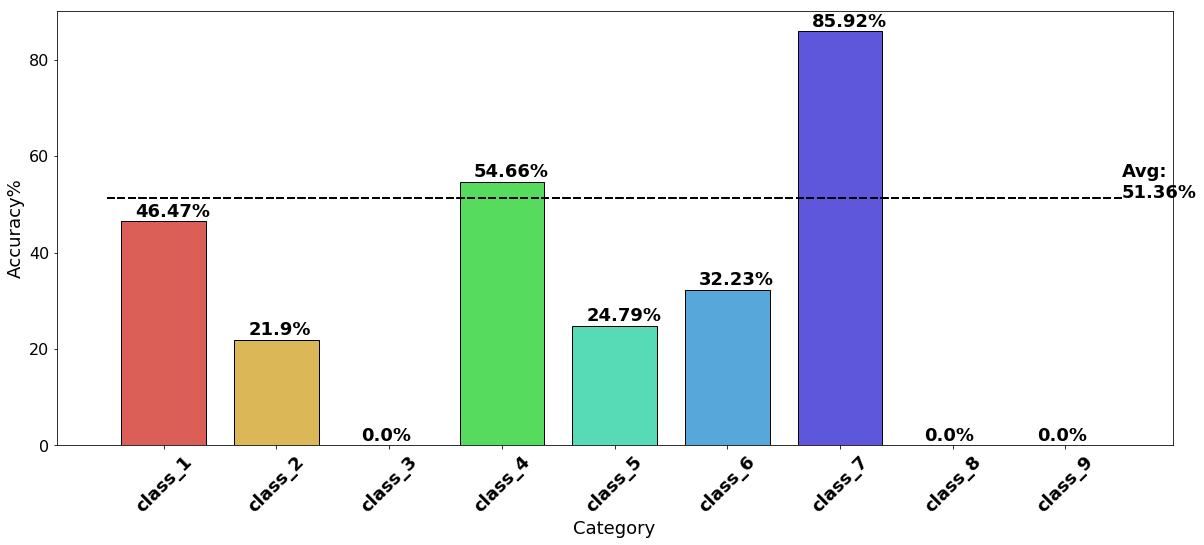

In [170]:
plot_acc_bar(cm,51.36)

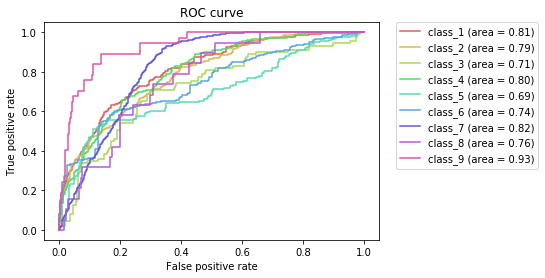

In [171]:
plot_ROC_curve(output)

<a id='Part2.6.4.2_link'></a>
### 2.6.4.2 RandomForestClassifier

* Model: RandomForestClassifier

max_depth: [   1    3    5   10   20   50  100 1000]
train_mean: [0.38019813 0.50642176 0.60403487 0.82728289 0.90176582 0.90410241
 0.90410241 0.90410241]
test_mean: [0.34778932 0.42203053 0.44401554 0.45935108 0.44430616 0.44279104
 0.44279104 0.44279104]
--------------------------------------------------------------------------------
max_depth: 10 achieves highest test score: 0.45935107673771924
--------------------------------------------------------------------------------


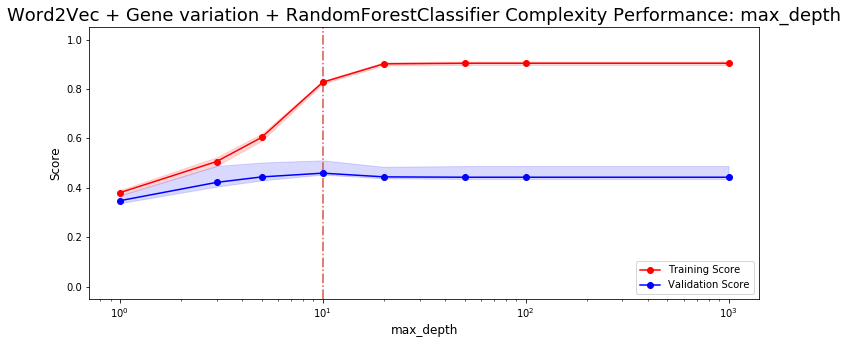

In [172]:
X=train_set
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
max_depth=np.array([1,3,5,10,20,50,100,None])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'max_depth', param_range = max_depth, cv = cv, scoring = 'accuracy')
max_depth=np.array([1,3,5,10,20,50,100,1000])
title='Word2Vec + Gene variation + RandomForestClassifier Complexity Performance: max_depth'
plot_val_curve(train_scores,test_scores,'max_depth', max_depth,title,logx=True)

min_samples_leaf: [  1   5  15 100 300 500]
train_mean: [0.90410241 0.81597082 0.71094715 0.51847446 0.43088741 0.39097849]
test_mean: [0.44279104 0.48974659 0.44580697 0.43164888 0.39449063 0.37910294]
--------------------------------------------------------------------------------
min_samples_leaf: 5 achieves highest test score: 0.4897465903717634
--------------------------------------------------------------------------------


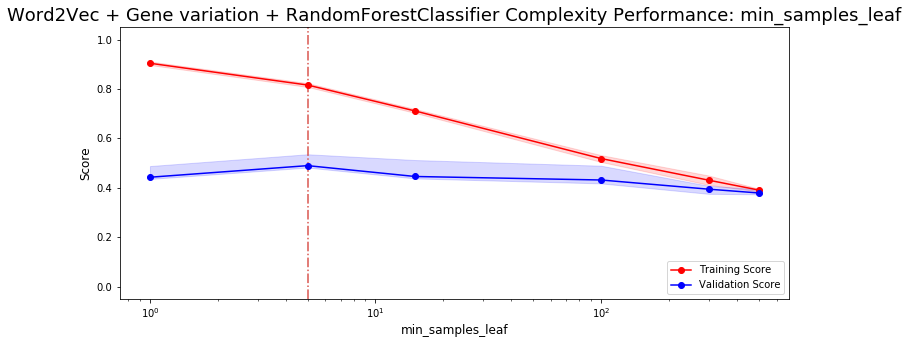

In [173]:
X=train_set
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
min_samples_leaf=np.array([1,5,15,100,300,500])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'min_samples_leaf', param_range = min_samples_leaf, cv = cv, scoring = 'accuracy')
title='Word2Vec + Gene variation + RandomForestClassifier Complexity Performance: min_samples_leaf'
plot_val_curve(train_scores,test_scores,'min_samples_leaf', min_samples_leaf,title,logx=True)

In [174]:
X=train_set
y=train_df.Class.values
clf = RandomForestClassifier(max_depth=5,min_samples_leaf=5,n_jobs=-1,random_state=8)
output = model_eval(clf, X,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


accuracy score: 0.45355850422195415
log_loss: 1.511967244320419


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


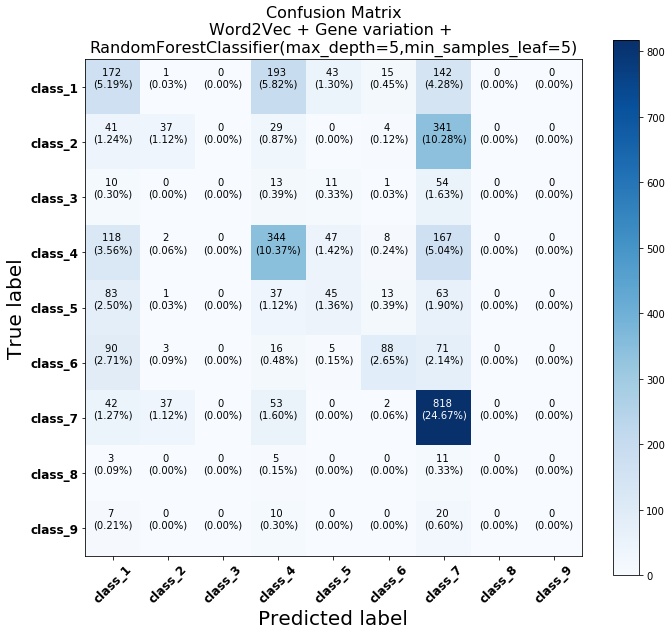

In [175]:
cm = confusion_matrix(train_df.Class.values, output.pred)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nWord2Vec + Gene variation + \nRandomForestClassifier(max_depth=5,min_samples_leaf=5)', cmap=plt.cm.Blues)

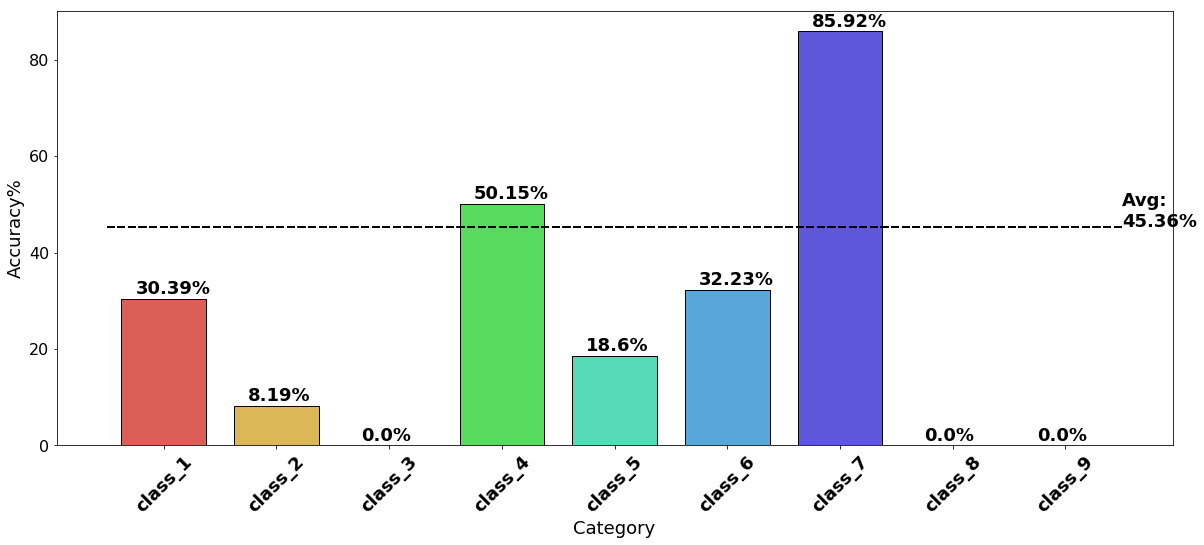

In [176]:
plot_acc_bar(cm,45.36)

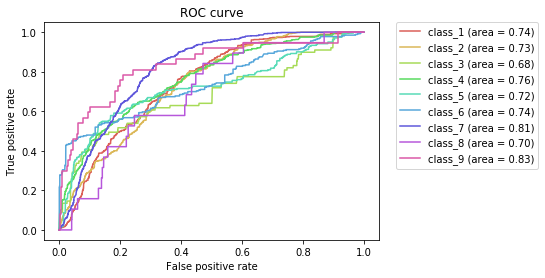

In [177]:
plot_ROC_curve(output)

<a id='Part2.6.4.3_link'></a>
### 2.6.4.3 XGBClassifier

* Model: XGBClassifier

colsample_bytree: [0.2 0.4 0.6 0.8 1. ]
train_mean: [0.84439556 0.85268611 0.85736058 0.85841525 0.86316429]
test_mean: [0.47540389 0.46602274 0.45821585 0.45635369 0.4518682 ]
--------------------------------------------------------------------------------
colsample_bytree: 0.2 achieves highest test score: 0.47540388979374076
--------------------------------------------------------------------------------


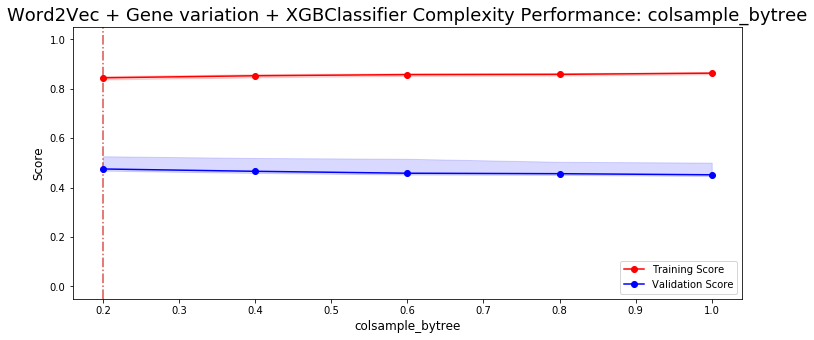

In [178]:
X=train_set
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
colsample_bytree=np.array([0.2, 0.4, 0.6, 0.8, 1.0])
train_scores, test_scores = validation_curve(XGBClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'colsample_bytree', param_range = colsample_bytree, cv = cv, scoring = 'accuracy')
title='Word2Vec + Gene variation + XGBClassifier Complexity Performance: colsample_bytree'
plot_val_curve(train_scores,test_scores,'colsample_bytree', colsample_bytree,title,logx=False)

min_child_weight: [ 1  3  5  8 10 20]
train_mean: [0.86316429 0.85381605 0.8448448  0.83647617 0.83150103 0.81016408]
test_mean: [0.4518682  0.45875099 0.450641   0.46300666 0.45400979 0.46788275]
--------------------------------------------------------------------------------
min_child_weight: 20 achieves highest test score: 0.46788274841421496
--------------------------------------------------------------------------------


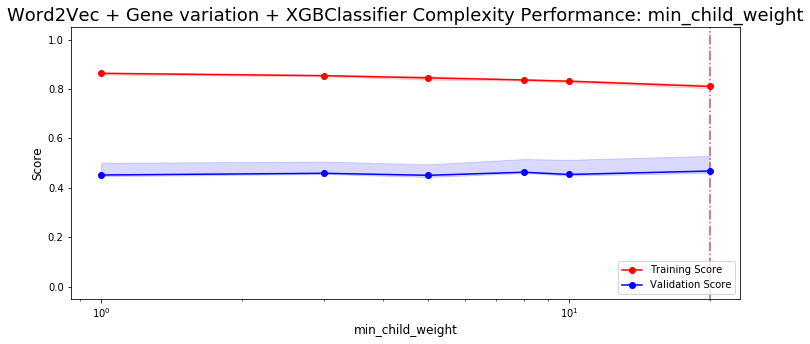

In [179]:
X=train_set
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
min_child_weight=np.array([1, 3, 5, 8, 10, 20])
train_scores, test_scores = validation_curve(XGBClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'min_child_weight', param_range = min_child_weight, cv = cv, scoring = 'accuracy')
title='Word2Vec + Gene variation + XGBClassifier Complexity Performance: min_child_weight'
plot_val_curve(train_scores,test_scores,'min_child_weight', min_child_weight,title,logx=True)

In [180]:
X=train_set
y=train_df.Class.values
clf = XGBClassifier(colsample_bytree=0.2,min_child_weight=20)
output = model_eval(clf, X,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.8s remaining:   20.7s


accuracy score: 0.47919179734620027
log_loss: 1.5028549881395856


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.0s finished


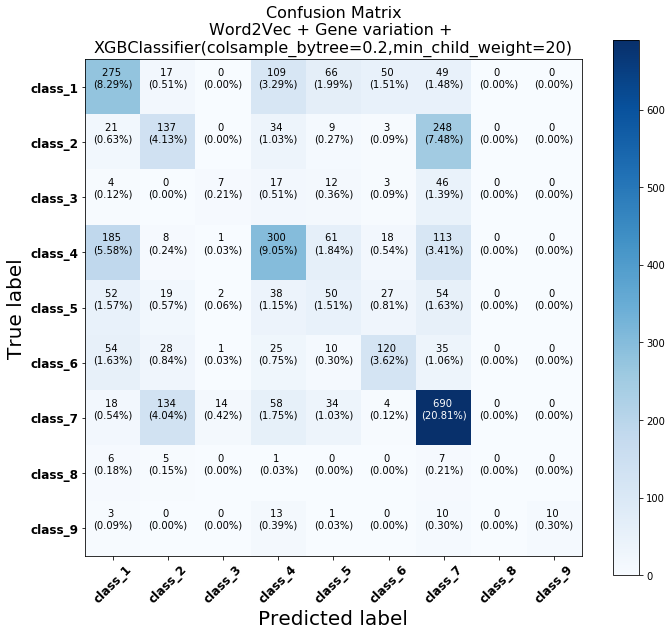

In [181]:
cm = confusion_matrix(train_df.Class.values, output.pred)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nWord2Vec + Gene variation + \nXGBClassifier(colsample_bytree=0.2,min_child_weight=20)', cmap=plt.cm.Blues)

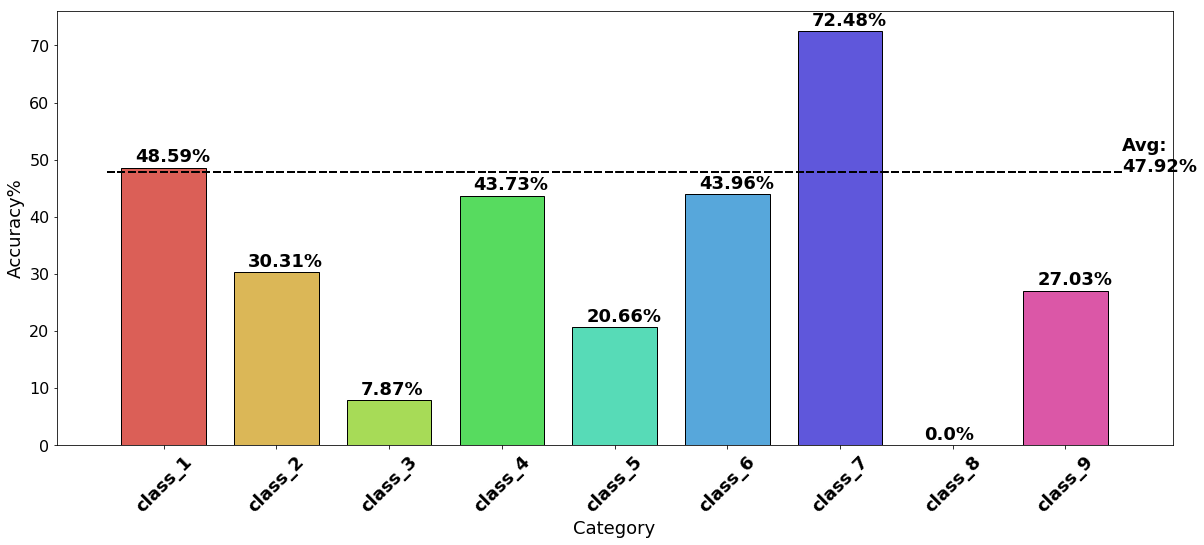

In [182]:
plot_acc_bar(cm,47.92)

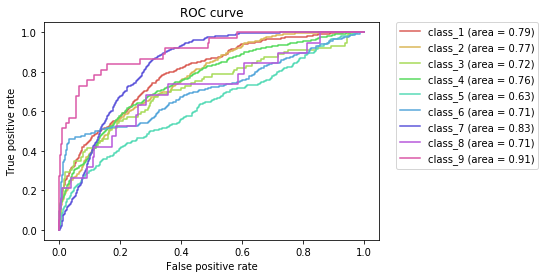

In [183]:
plot_ROC_curve(output)

## Conclusion for Word2Vec

1. The overall training performance for Word2Vec model is comparable to BOW method and better than LSA. **XGBClassifier(min_child_weight=5)** can achieve an overall accuracy score 0.48.
2. Word2Vec model with gene variation information performs slightly better, with overall validation accuracy around 0.51 for **LogisticRegression(C=0.001)**.
3. The Word2Vec embedding matrix can transform words to numeric vectors with specific semantic meanings in terms of tumor malignancy.